In [1]:
!pip install -q -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 73.7 MB/s eta 0:00:00


# Load Model

In [2]:
! pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187815463 sha256=d944fc7d2f962bce83fc4708c2fc0c21eaf8255962a0b350ae919362a51b7ef2
  Stored in directory: /root/.cache/pip/wheels/3d/88/d8/284b89f56af7d5bf366b10d6b8e251ac8a7c7bf3f04203fb4f
Successfully built flash-attn
  At

In [3]:
import torch
import random
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

model_path="/kaggle/input/gemma-2/transformers/gemma-2-9b-it/1"

tokenizer=AutoTokenizer.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.bfloat16,
    device_map = "auto",
    trust_remote_code = True,
)

2025-04-13 12:52:02.532012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744548722.921682      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744548723.039202      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The model is loaded to both the T4 GPUs in ~3minutes. Here is how the memory used.

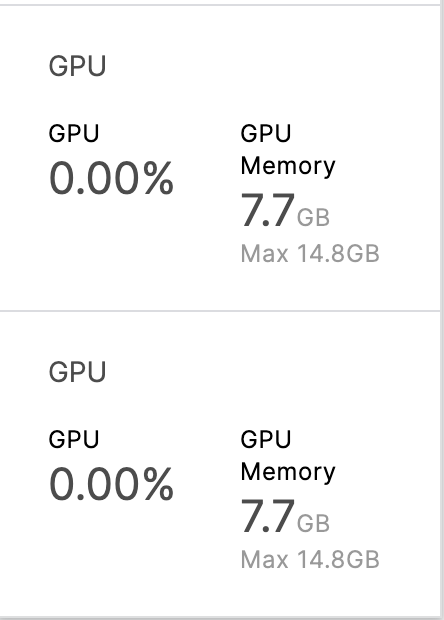

T4 GPUs are a great fit for these tasks compared to P100 due to the lower memory on the latter.

In [4]:
%%time

def generate_essay(prompt, max_tokens):

    messages = [
    {"role": "user", "content": prompt}
    ]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")

    if max_tokens == 0:
        max_tokens = 100
        
    outputs = model.generate(**input_ids, max_new_tokens=max_tokens)
    return tokenizer.decode(outputs[0])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.78 µs


# Read Prompts

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_texts.txt", "r", encoding="utf-8") as file:
    text = file.read()

text_list = text.split('\n')

with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_entities.txt", "r", encoding="utf-8") as file:
    text = file.read()

labels_list = text.split('\n')

In [6]:
df = pd.DataFrame()
df['train_text'] = text_list
df['train_labels'] = labels_list

In [7]:
df['train_text_list'] = df['train_text'].str.split(' ')
df['train_labels_list'] = df['train_labels'].str.split(' ')

In [8]:
df['unique_labels'] = df['train_labels_list'].apply(lambda x: ' '.join(list(set(x))))

In [9]:
df['document'] = np.arange(len(df))

In [10]:
all_labels = [
    'B-Extension','I-Extension','B-Application','I-Application','B-Abbreviation','B-Citation','I-Citation',
    'B-SoftwareCoreference','I-SoftwareCoreference','B-URL','I-URL','B-AlternativeName', 'I-AlternativeName',
    'B-OperatingSystem','I-OperatingSystem','B-Developer','I-Developer','O','B-License','I-License','B-PlugIn','I-PlugIn',
    'B-Release','I-Release','B-ProgrammingEnvironment','I-ProgrammingEnvironment','B-Version','I-Version']

id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
target = [l for l in all_labels if l != "O"]

In [11]:
from collections import defaultdict

def bundle_entities(tokens, labels):
    entity_dict = defaultdict(list)
    current_entity_tokens = []
    current_label = None

    for token, label in zip(tokens, labels):
        if label == 'O':  # Reset when outside an entity
            if current_entity_tokens and current_label:
                entity_dict[current_label].append(" ".join(current_entity_tokens))
            current_entity_tokens = []
            current_label = None
            continue

        # If we encounter a new entity (either 'B-' or 'I-' type)
        entity = label

        # If we are starting a new entity, process the previous one first
        if current_entity_tokens and current_label != entity:
            entity_dict[current_label].append(" ".join(current_entity_tokens))
            current_entity_tokens = []  # Reset the tokens for the new entity

        # Add the current token to the current entity
        current_entity_tokens.append(token)
        current_label = entity

    # Add last entity if it exists
    if current_entity_tokens and current_label:
        entity_dict[current_label].append(" ".join(current_entity_tokens))

    return dict(entity_dict)

In [12]:
l = []
for i in range(0, len(df)):
    l.append(bundle_entities(df.values[i][2], df.values[i][3]))

In [13]:
# Merging all entity values
merged_entities = defaultdict(set)

for entity_dict in l:
    for entity, values in entity_dict.items():
        merged_entities[entity].update(values)  # Using a set to remove duplicates

# Convert back to lists
merged_entities = {key: list(values) for key, values in merged_entities.items()}

# Generate Texts

In [14]:
llm_essays = []
essay_counter = 0

np.random.seed(73)  
all_numbers_1 = list(range(0, len(df)))
np.random.shuffle(all_numbers_1)

np.random.seed(37)  
all_numbers_2 = list(range(0, len(df)))
np.random.shuffle(all_numbers_2) 

In [15]:
for p1, p2 in zip(all_numbers_1, all_numbers_2):
    merged_labels = {}
    try:
        for key in set(l[p1].keys()).union(set(l[p2].keys())):
            merged_labels[key] = l[p1].get(key, []) + l[p2].get(key, [])

        print(p1, p2)
            
        combined = [item for sublist in merged_labels.values() for item in sublist]
        prompt_combined = f'''
                merge these 2 texts and rephrase on syntactic and semantic level 
                text1  - {df['train_text'].values[p1]}.
                text2  - {df['train_text'].values[p2]}.
                KEEP THESE TOKENS in merged text as it is - {combined}.
                ONLY GIVE THE FINAL MERGED TEXT NO ADDITIONAL TEXT.
                '''
        # generate the essay
        essay_output = generate_essay(prompt_combined, int((len(df['train_text'].values[p1]) + len(df['train_text'].values[p2]))//1))
        essay_output = essay_output.split('<end_of_turn>')[1].split('\n\n\n')[1]
        essay_counter += 1
    
        labels = {value: key for key, values in merged_labels.items() for value in values}
    
        tokens = text.strip().split(' ')
    
        labeled_tokens = [labels.get(token, "O") for token in tokens]
        
        output = " ".join(labeled_tokens)

    
        data_output = {
            'text_id_1': p1,
            'text_id_2': p2,
            'original_text_1': df['train_text'].values[p1],
            'original_text_2': df['train_text'].values[p2],
            'labels_1': df['train_labels'].values[p1],
            'labels_2': df['train_labels'].values[p2],
            'augmented_text': essay_output,
            'labels': output
        }
        llm_essays.append(data_output)
    except:
        print(p1, p2, 'error')
        pass

574 1058
656 210
685 1034
986 840
906 574
504 496
353 181
869 558
616 838
111 793
534 996
1061 148
697 909
945 938
421 1071
204 748
603 11
470 846
905 69
262 865
997 508
219 595
725 408
664 92
28 875
776 944
176 233
1046 851
493 780
948 945
541 764
850 534
26 200
1051 284
70 1090
543 771
331 138
341 1103
926 65
786 678
1007 168
524 924
410 266
588 183
271 983
551 490
183 179
557 877
1066 895
433 13
412 1006
41 884
448 669
660 521
512 2
50 1069
465 38
910 264
130 952
659 1101
789 1097
924 908
833 719
24 919
180 530
171 274
406 540
740 982
416 388
1089 447
718 745
836 1020
305 162
617 153
613 271
667 369
870 790
854 1013
843 122
57 668
3 1134
464 260
619 858
1053 693
427 850
1131 763
491 49
238 358
842 544
731 631
621 1131
14 290
932 277
359 422
565 797
980 468
1140 262
27 446
751 537
441 1033
280 643
671 663
532 1028
847 815
655 986
349 730
1026 837
700 37
903 313
966 471
1042 294
124 922
172 915
959 913
1020 898
763 191
645 775
834 864
954 625
515 1109
301 253
549 1038
332 572
185 781


In [16]:
llm_essays = pd.DataFrame(llm_essays)
llm_essays.to_csv('augmented_gemma_2_9b.csv', index = False)